<a href="https://colab.research.google.com/github/michael-0907/tibami/blob/main/bank_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gradio

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBClassifier

import joblib
import gradio as gr



In [63]:
data = pd.read_csv("/content/sample_data/bank-full.csv", encoding="utf-8", sep=";")
data.shape

(45211, 17)

In [61]:
# df = data.copy()

# 刪除有 unknkwn 的行
df = data[~data.isin(["unknown"]).any(axis=1)].copy()

df.shape


(7842, 17)

In [102]:
display(df.shape)
column_info = []
for col in df.columns:
  c = [col, df[col].dtype, df[col].isna().any(), df[col].nunique(), df[col].unique()[0: 20]]
  column_info.append(c)
columns = ["col_name", "dtype", "isna", "unique_num", "unique_20"]
column_info_df = pd.DataFrame(column_info, columns=columns)
display(column_info_df)



(7842, 17)

,col_name,dtype,isna,unique_num,unique_20
0,age,int64,False,70,"[33, 42, 36, 44, 26, 51, 30, 34, 49, 47, 40, 3..."
1,job,object,False,11,"[admin., services, management, blue-collar, te..."
2,marital,object,False,3,"[married, single, divorced]"
3,education,object,False,3,"[tertiary, secondary, primary]"
4,default,object,False,2,"[no, yes]"
5,balance,int64,False,3090,"[882, -247, 3444, 2415, 0, 1324, 172, 3132, 10..."
6,housing,object,False,2,"[no, yes]"
7,loan,object,False,2,"[no, yes]"
8,contact,object,False,2,"[telephone, cellular]"
9,day,int64,False,31,"[21, 22, 23, 25, 4, 5, 10, 12, 13, 17, 18, 19,..."


In [103]:
for col in df.columns:
  unknown_col = df[col].isin(["unknown"])
  if unknown_col.any():
    print(f"含有unknown的特徵: {col}, 數量: {unknown_col.sum()}")
unknown_row = df.isin(["unknown"]).any(axis=1)
print(f"總行數: {df.shape[0]}")
print(f"含有unknown的行數: {unknown_row.sum()}")

總行數: 7842
含有unknown的行數: 0


In [54]:
# 顯示特徵屬性分佈
df.dtypes.value_counts()

,count
object,10
int64,7


In [104]:
# 處理特徵變數 - month
df["month"] = df["month"].map({'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'oct': 10,
                    'nov': 11 ,'dec': 12, 'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'sep': 9}).astype(float)
df["day"] = df["day"].astype(float)


In [105]:
# 處理二元特徵變數
for col in df.select_dtypes(include=["object"]).columns:
  if df[col].isin(["yes", "no"]).any():
    df[col] = df[col].map({"yes": 1, "no": 0})

In [106]:
# 提取數值欄位，含目標變數
numerical_columns = []
for col in df.select_dtypes(include=["int64"]):
  numerical_columns.append(col)
print(f"{len(numerical_columns)}, {numerical_columns}")

10, ['age', 'default', 'balance', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'y']


In [ ]:
# 確認數值變數的相關性係數
corr_matrix = df[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")

In [ ]:
# 畫出數值型特徵的分佈
fig, axes = plt.subplots(3, 4, figsize=(11.33, 7.5))
ax = axes.flatten()
for i, col in enumerate(numerical_columns):
  sns.histplot(data=df, x=col, ax=ax[i])
plt.tight_layout()

In [ ]:
# 畫出數值型特徵的分佈
fig, axes = plt.subplots(3, 4, figsize=(11.33, 7.5))
ax = axes.flatten()
for i, col in enumerate(numerical_columns):
  sns.boxplot(data=df, x="y", y=col, ax=ax[i])
plt.tight_layout()


In [ ]:
sns.countplot(data=df, x="month", hue="y")

In [ ]:
# 畫出類別特徵與目標變數的 countplot
fig, axes = plt.subplots(3, 2, figsize=(11.33, 7.5))
ax = axes.flatten()
for i, col in enumerate(['job', 'marital', 'education', 'contact', 'poutcome']):
  sns.countplot(data=df, x=col, ax=ax[i])
plt.tight_layout()

In [ ]:
# 畫出類別特徵與目標變數的 countplot
fig, axes = plt.subplots(3, 2, figsize=(11.33, 7.5))
ax = axes.flatten()
for i, col in enumerate(['job', 'marital', 'education', 'contact', 'poutcome']):
  sns.countplot(data=df, x=col, hue="y", ax=ax[i])
plt.tight_layout()

In [107]:
# 提取特徵和目標變數
X = df.drop(columns=["y"])
y = df["y"]
print(X.shape, y.shape)
print(X.dtypes.value_counts())

(7842, 16) (7842,)
int64      9
object     5
float64    2
Name: count, dtype: int64


In [108]:
# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
display(X_train.head(3))
display(X_test.head(3))


(6273, 16) (6273,)
(1569, 16) (1569,)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
31160,35,technician,divorced,secondary,0,2823,1,0,cellular,26.0,2.0,74,1,24,1,failure
34803,40,management,married,tertiary,0,-606,1,0,cellular,6.0,5.0,90,1,345,1,failure
40055,42,management,married,tertiary,0,2665,1,0,cellular,4.0,6.0,280,2,126,11,failure


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
31466,59,retired,married,secondary,0,1035,1,1,cellular,1.0,4.0,126,2,239,1,failure
30415,49,blue-collar,married,primary,0,1,0,1,cellular,5.0,2.0,98,1,210,1,other
34439,27,services,single,secondary,0,-72,1,0,cellular,5.0,5.0,276,1,309,9,failure


In [109]:
# 特徵分組

categorical_features = ['marital', 'education', 'contact', 'poutcome'] # 做標籤編碼
frequency_features = ['job', 'day', 'month'] # 做頻率編碼
binary_features = ['default', 'housing', 'loan'] # 已經處理過，不用再處理
outlier_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'] # 考慮做 RobustScaler 縮放

print(len(categorical_features) + len(frequency_features) + len(binary_features) + len(outlier_features))



16


In [110]:

# 設置預處理器，並指定欄位
preprocessor = ColumnTransformer(transformers=[
    ("outlier", "passthrough", outlier_features),
    ("binary", "passthrough", binary_features),
    ("categorical", OrdinalEncoder(handle_unknown="error"), categorical_features),
    ("frequency", "passthrough", frequency_features)
])


In [111]:

# 執行頻率編碼預處理，並把編碼map 儲存起來

frequency_map_ = {}
for col in frequency_features:
  frequency_map_[col] = X_train[col].value_counts(normalize=True).round(4).to_dict()
  X_train[col] = X_train[col].map(frequency_map_[col])
  X_test[col] = X_test[col].map(frequency_map_[col])
frequency_map_




{'job': {'management': 0.2233,
  'blue-collar': 0.1977,
  'technician': 0.1626,
  'admin.': 0.132,
  'services': 0.0877,
  'retired': 0.059,
  'self-employed': 0.0327,
  'student': 0.0322,
  'entrepreneur': 0.0279,
  'unemployed': 0.0266,
  'housemaid': 0.0183},
 'day': {18.0: 0.0633,
  15.0: 0.0583,
  17.0: 0.0575,
  20.0: 0.0561,
  13.0: 0.0547,
  12.0: 0.0499,
  14.0: 0.0435,
  6.0: 0.0434,
  5.0: 0.043,
  4.0: 0.0418,
  11.0: 0.0405,
  7.0: 0.0389,
  2.0: 0.0387,
  8.0: 0.0368,
  21.0: 0.0354,
  29.0: 0.0351,
  30.0: 0.0314,
  3.0: 0.0306,
  19.0: 0.0298,
  16.0: 0.0271,
  9.0: 0.0231,
  28.0: 0.0207,
  26.0: 0.0174,
  1.0: 0.014,
  22.0: 0.014,
  25.0: 0.0128,
  10.0: 0.0115,
  27.0: 0.011,
  23.0: 0.0091,
  24.0: 0.0069,
  31.0: 0.0037},
 'month': {5.0: 0.3073,
  11.0: 0.1419,
  4.0: 0.1373,
  2.0: 0.1153,
  8.0: 0.0628,
  1.0: 0.0595,
  6.0: 0.0389,
  10.0: 0.0384,
  9.0: 0.0357,
  7.0: 0.0293,
  3.0: 0.0193,
  12.0: 0.0143}}

In [112]:
# 執行columntransformer 預處理

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

print(X_train_preprocessed.shape, y_train.shape)
print(X_test_preprocessed.shape, y_test.shape)


(6273, 16) (6273,)
(1569, 16) (1569,)


In [113]:
all_feature_names = outlier_features + binary_features + categorical_features + frequency_features

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=all_feature_names, index=X_train.index, dtype=float)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=all_feature_names, index=X_test.index, dtype=float)
print(X_train_preprocessed.shape, y_train.shape)
print(X_test_preprocessed.shape, y_test.shape)
display(X_train_preprocessed.head(3))
display(X_test_preprocessed.head(3))


(6273, 16) (6273,)
(1569, 16) (1569,)


,age,balance,duration,campaign,pdays,previous,default,housing,loan,marital,education,contact,poutcome,job,day,month
31160,35.0,2823.0,74.0,1.0,24.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.1626,0.0174,0.1153
34803,40.0,-606.0,90.0,1.0,345.0,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.2233,0.0434,0.3073
40055,42.0,2665.0,280.0,2.0,126.0,11.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.2233,0.0418,0.0389


,age,balance,duration,campaign,pdays,previous,default,housing,loan,marital,education,contact,poutcome,job,day,month
31466,59.0,1035.0,126.0,2.0,239.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0590,0.014,0.1373
30415,49.0,1.0,98.0,1.0,210.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.1977,0.043,0.1153
34439,27.0,-72.0,276.0,1.0,309.0,9.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0877,0.043,0.3073


In [114]:
# 目前測最佳超參數,threshold=0.65(含所有特徵)
# model = RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_leaf=5, class_weight="balanced", random_state=42)


model = RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_leaf=3, class_weight="balanced", random_state=42)

# model = XGBClassifier(
#     n_estimators=300,    # 增加树的数量
#     learning_rate=0.05,  # 降低学习率（减少单棵树的影响）
#     max_depth=3,         # 降低树的深度
#     subsample=0.7,       # 采样 80% 数据
#     colsample_bytree=0.7, # 采样 80% 特征
#     min_child_weight=6,  # 增加到 5，防止误分类
#     reg_lambda=15,       # L2 正则化，减少过拟合
#     objective='binary:logistic',
#     eval_metric='logloss',
#     max_delta_step=1,     # 类别不均衡调整
#     scale_pos_weight=1.3,  # 处理类别不均衡（计算方式见下方）
#     random_state=42
# )


model.fit(X_train_preprocessed, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=3, n_estimators=150, random_state=42)

In [115]:
y_train_proba = model.predict_proba(X_train_preprocessed)[:,1]
threshold = 0.5
y_train_pred = (y_train_proba >= threshold).astype("int")
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)
print(f"train accuracy: {train_accuracy}")
print(train_report)

print("-" * 50)
y_test_proba = model.predict_proba(X_test_preprocessed)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype("int")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
print(f"test accuracy: {test_accuracy}")
print(test_report)



train accuracy: 0.9550454328072693
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4844
           1       0.85      0.97      0.91      1429

    accuracy                           0.96      6273
   macro avg       0.92      0.96      0.94      6273
weighted avg       0.96      0.96      0.96      6273

--------------------------------------------------
test accuracy: 0.8495857233906947
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1212
           1       0.64      0.77      0.70       357

    accuracy                           0.85      1569
   macro avg       0.78      0.82      0.80      1569
weighted avg       0.86      0.85      0.85      1569



In [116]:
feature_importance = model.feature_importances_
sorted_index = np.argsort(feature_importance)[::-1]
sorted_feature = np.array(X_train_preprocessed.columns)[sorted_index]
sorted_importance = feature_importance[sorted_index]

important_features = []
threshold = 0.01
for i, j in zip(sorted_feature, sorted_importance):
  if j >= threshold:
    important_features.append(i)
    print(f"{i}: {j}")
print(important_features)

duration: 0.2803947204451167
poutcome: 0.16455906888705044
pdays: 0.10087047690535499
month: 0.09925834457554442
housing: 0.07412835599171125
day: 0.06953255762464294
balance: 0.05696799606398841
age: 0.047499492863590564
job: 0.025697691422131748
previous: 0.024763473785992324
campaign: 0.019055164622519754
education: 0.01531767333837658
marital: 0.010353343487285567
['duration', 'poutcome', 'pdays', 'month', 'housing', 'day', 'balance', 'age', 'job', 'previous', 'campaign', 'education', 'marital']


In [171]:
fil = ["pdays", "balance", "age", "previous", "campaign", "housing", "poutcome", "education", "job"]
X_train_important = X_train[fil]
X_test_important = X_test[fil]

print(X_train_important.shape, y_train.shape)
print(X_test_important.shape, y_test.shape)
display(X_train_important.head(3))
display(X_test_important.head(3))

(6273, 9) (6273,)
(1569, 9) (1569,)


,pdays,balance,age,previous,campaign,housing,poutcome,education,job
31160,24,2823,35,1,1,1,failure,secondary,0.1626
34803,345,-606,40,1,1,1,failure,tertiary,0.2233
40055,126,2665,42,11,2,1,failure,tertiary,0.2233


,pdays,balance,age,previous,campaign,housing,poutcome,education,job
31466,239,1035,59,1,2,1,failure,secondary,0.0590
30415,210,1,49,1,1,0,other,primary,0.1977
34439,309,-72,27,9,1,1,failure,secondary,0.0877


In [172]:

# 設置預處理器，並指定欄位
preprocessor_important = ColumnTransformer(transformers=[
    ("outlier", "passthrough", ["pdays", "balance", "age", "previous", "campaign"]),
    ("binary", "passthrough", ["housing"]),
    ("categorical", OrdinalEncoder(handle_unknown="error"), ["poutcome", "education"]),
    ("frequency", "passthrough", ["job"])
])


In [173]:
X_train_important = preprocessor_important.fit_transform(X_train_important)
X_test_important = preprocessor_important.transform(X_test_important)

print(X_train_important.shape, y_train.shape)
print(X_test_important.shape, y_test.shape)


(6273, 9) (6273,)
(1569, 9) (1569,)


In [174]:

X_train_important = pd.DataFrame(X_train_important, columns=fil, index=X_train.index, dtype=float)
X_test_important = pd.DataFrame(X_test_important, columns=fil, index=X_test.index, dtype=float)
print(X_train_important.shape, y_train.shape)
print(X_test_important.shape, y_test.shape)
display(X_train_important.head(3))
display(X_test_important.head(3))


(6273, 9) (6273,)
(1569, 9) (1569,)


,pdays,balance,age,previous,campaign,housing,poutcome,education,job
31160,24.0,2823.0,35.0,1.0,1.0,1.0,0.0,1.0,0.1626
34803,345.0,-606.0,40.0,1.0,1.0,1.0,0.0,2.0,0.2233
40055,126.0,2665.0,42.0,11.0,2.0,1.0,0.0,2.0,0.2233


,pdays,balance,age,previous,campaign,housing,poutcome,education,job
31466,239.0,1035.0,59.0,1.0,2.0,1.0,0.0,1.0,0.0590
30415,210.0,1.0,49.0,1.0,1.0,0.0,1.0,0.0,0.1977
34439,309.0,-72.0,27.0,9.0,1.0,1.0,0.0,1.0,0.0877


In [175]:
# 保存 預處理器
joblib.dump((preprocessor_important, frequency_map_), 'preprocessor_important.pkl')

['preprocessor_important.pkl']

In [176]:

model_important = RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_leaf=3, class_weight="balanced", random_state=42)

model_important.fit(X_train_important, y_train)



RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=3, n_estimators=150, random_state=42)

In [177]:
joblib.dump(model_important, 'model_important.pkl')

['model_important.pkl']

In [179]:
y_train_proba = model_important.predict_proba(X_train_important)[:,1]
threshold = 0.5
y_train_pred = (y_train_proba >= threshold).astype("int")
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)
print(f"train accuracy: {train_accuracy}")
print(train_report)

print("-" * 50)
y_test_proba = model_important.predict_proba(X_test_important)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype("int")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
print(f"test accuracy: {test_accuracy}")
print(test_report)


train accuracy: 0.937350549976088
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      4844
           1       0.83      0.91      0.87      1429

    accuracy                           0.94      6273
   macro avg       0.90      0.93      0.91      6273
weighted avg       0.94      0.94      0.94      6273

--------------------------------------------------
test accuracy: 0.8234544295729764
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1212
           1       0.62      0.58      0.60       357

    accuracy                           0.82      1569
   macro avg       0.75      0.74      0.74      1569
weighted avg       0.82      0.82      0.82      1569



In [186]:
preprocessor_loaded, frequency_map_loaded = joblib.load("/content/preprocessor_important.pkl")
model_important_loaded = joblib.load("/content/model_important.pkl")
preprocessor_loaded
frequency_map_loaded["job"]
model_important_loaded

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=3, n_estimators=150, random_state=42)

In [197]:

input_data = [[1, 1, 1, 1, 1, 1, 'success', 'primary', 'management']]

gr_df = pd.DataFrame(input_data, columns=fil)
gr_df
gr_df["job"] = gr_df["job"].map(frequency_map_loaded["job"])
gr_df
gr_preprocessed = preprocessor_loaded.transform(gr_df)
gr_preprocessed
gr_preprocessed = pd.DataFrame(gr_preprocessed, columns=fil)
gr_preprocessed

threshold = 0.5
y_test_proba = model_important_loaded.predict_proba(gr_preprocessed)
print(y_test_proba)
y_test_proba

array([[0.47418951, 0.52581049]])

In [209]:
fil = ["pdays", "balance", "age", "previous", "campaign", "housing", "poutcome", "education", "job"]

def func_predict(pdays, balance, age, previous, campaign, housing, poutcome, education, job):
  input_data = np.array([[pdays, balance, age, previous, campaign, housing, poutcome, education, job]]) # 格式轉換為二維numpy
  gr_df = pd.DataFrame(input_data, columns=fil)
  gr_df["job"] = gr_df["job"].map(frequency_map_loaded["job"])
  gr_df["housing"] = gr_df["housing"].map({"yes": 1, "no": 0}).astype(float)
  gr_df["poutcome"] = gr_df["poutcome"].map({"no_record": "other"}).fillna(gr_df["poutcome"])

  gr_df = preprocessor_loaded.transform(gr_df)
  gr_df = pd.DataFrame(gr_df, columns=fil)

  # threshold = 0.5
  y_test_proba = model_important_loaded.predict_proba(gr_df)

  return y_test_proba

model_predict = gr.Interface(
    fn = func_predict,
    inputs = [
        gr.Slider(minimum=-1, maximum=854, step=1, value=1,
                  label="上次活動以來與客戶聯繫後的天數(-1表示之前未與客戶聯繫): "), #  pdays
        gr.Slider(minimum=-1800, maximum=80000, step=100, value=1, label="平均年餘額: "), # balance
        gr.Slider(minimum=18, maximum=90, step=1, value=1, label="年齡: "), # age
        gr.Slider(minimum=1, maximum=275, step=1, value=1, label="在此活動之前的聯繫次數: "), # previous
        gr.Slider(minimum=1, maximum=14, step=1, value=1, label="聯繫次數: "), # campaign
        gr.Radio(["yes", "no"], label="是否有房貸: ", value="yes"), # housing
        gr.Radio(["success", "failure", "no_record"], label="前一次行銷活動的結果: ", value="success"), # poutcome
        gr.Radio(['secondary', 'tertiary', 'primary'], label="education: ", value="primary"),  # education
        gr.Radio(['technician', 'management', 'admin.', 'retired', 'blue-collar', 'entrepreneur',
                  'student', 'services', 'unemployed', 'self-employed',
                  'housemaid'], label="職業: ", value="management") # job
    ],
    outputs = gr.Textbox(label="result: "),
    title = "這是 title",
    description = "這是 description"
)


model_predict.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://62a49eb376965ba8bd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
column_info = []
for col in X_train_preprocessed.columns:
  info_dtype = X_train_preprocessed[col].dtype
  info_isna = X_train_preprocessed[col].isna().any()
  info_nunique = X_train_preprocessed[col].nunique()
  info_min = X_train_preprocessed[col].min()
  info_max = X_train_preprocessed[col].max()
  info_unique_20 = X_train_preprocessed[col].unique()[0: 20]

  c = [col, info_dtype, info_isna, info_nunique, info_min, info_max, info_unique_20]
  column_info.append(c)
columns = ["col_name", "dtype", "isna", "unique_num", "min", "max", "unique_20"]
column_info_df = pd.DataFrame(column_info, columns=columns)
display(X_train_preprocessed.columns)
display(column_info_df)


Index(['poutcome', 'pdays', 'housing', 'balance', 'age', 'previous', 'job',
       'campaign', 'education'],
      dtype='object')

,col_name,dtype,isna,unique_num,min,max,unique_20
0,poutcome,float64,False,3,0.000000,2.000000,"[0.0, 2.0, 1.0]"
1,pdays,float64,False,502,1.000000,854.000000,"[24.0, 345.0, 126.0, 96.0, 368.0, 206.0, 84.0,..."
2,housing,float64,False,2,0.000000,1.000000,"[1.0, 0.0]"
3,balance,float64,False,2714,-1884.000000,81204.000000,"[2823.0, -606.0, 2665.0, 303.0, 147.0, 162.0, ..."
4,age,float64,False,69,18.000000,89.000000,"[35.0, 40.0, 42.0, 34.0, 31.0, 48.0, 30.0, 57...."
5,previous,float64,False,38,1.000000,275.000000,"[1.0, 11.0, 3.0, 5.0, 4.0, 8.0, 13.0, 7.0, 2.0..."
6,job,float64,False,11,0.018333,0.223338,"[0.16260162601626016, 0.2233381157340985, 0.13..."
7,campaign,float64,False,13,1.000000,14.000000,"[1.0, 2.0, 3.0, 7.0, 4.0, 6.0, 5.0, 8.0, 12.0,..."
8,education,float64,False,3,0.000000,2.000000,"[1.0, 2.0, 0.0]"


In [ ]:
X_train["education"].unique()

array(['secondary', 'tertiary', 'primary'], dtype=object)

([0, 1, 2],
 [Text(0, 0, 'secondary'), Text(1, 0, 'tertiary'), Text(2, 0, 'primary')])

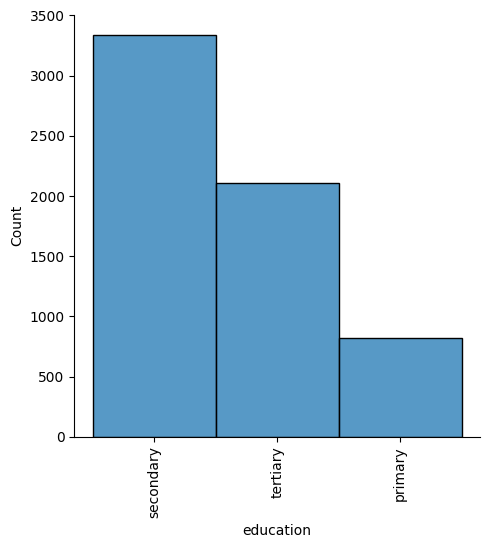

In [ ]:
sns.displot(data=X_train, x="education")
plt.xticks(rotation=90)

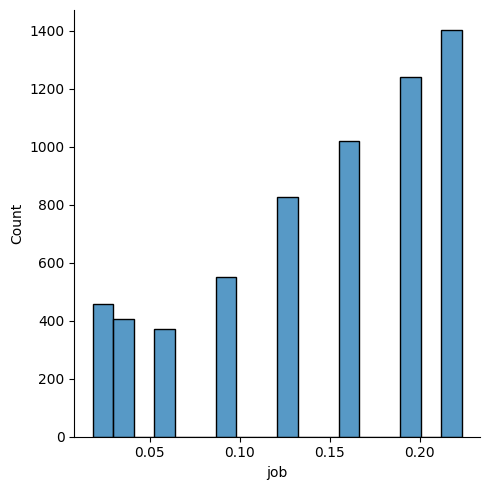

In [ ]:
sns.displot(data=X_train_preprocessed, x="job")